Step 1: Import Necessary Libraries.



In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

I imported all the necessary Python libraries for data manipulation (Pandas, NumPy)

Preprocessing (StandardScaler, OneHotEncoder from sklearn)

Model training (KMeans for clustering, RandomForestClassifier for feature importance)

Visualization (matplotlib for plotting). 

This setup ensures me have the tools required for each stage of the data analysis and modeling process.

Step 2: Load and Explore the Dataset i load the Airbnb listings.csv data into a Pandas DataFrame. This step is crucial for understanding the dataset's structure, including the number of observations, features, types of data contained (numerical, categorical), and initial signs of missing values or anomalies. It sets the foundation for the data cleaning and preprocessing steps by identifying what aspects of the dataset need attention..

In [3]:
# Load the data
df = pd.read_csv('listings.csv')

# Display the first few rows of the dataframe
print(df.head())

# General information about the dataset
print(df.info())

       id                                               name  host_id  \
0   26057  Home in Copenhagen · ★4.91 · 4 bedrooms · 4 be...   109777   
1   26473  Townhouse in Copenhagen · ★4.55 · 6 bedrooms ·...   112210   
2   29118  Rental unit in Copenhagen · ★4.85 · 1 bedroom ...   125230   
3  318437  Rental unit in Copenhagen · ★4.86 · 1 bedroom ...  1634152   
4   31094  Condo in Copenhagen · ★4.88 · 4 bedrooms · 2 b...   129976   

  host_name  neighbourhood_group              neighbourhood   latitude  \
0      Kari                  NaN                   Indre By  55.693070   
1     Julia                  NaN                   Indre By  55.676020   
2      Nana                  NaN  Vesterbro-Kongens Enghave  55.670230   
3     Ditti                  NaN                    Nrrebro  55.692680   
4      Ebbe                  NaN  Vesterbro-Kongens Enghave  55.666602   

   longitude        room_type   price  minimum_nights  number_of_reviews  \
0  12.576490  Entire home/apt  2900.0   

Step 3: Data Cleaning and Preparation


Data cleaning and preparation are critical to ensure the quality and usefulness of the data for analysis. This step involves:
  Dropping unnecessary columns: Columns that are not useful for the analysis or have a high percentage of missing values are removed. This reduces the complexity of the datase
t   Handling missing values: For numerical data, missing values are filled with the median, which is more robust to outliers than the mean. Categorical missing values are filled with the most frequent category or a placeholder value. This ensures the model can process the data without errors due to missing value
    Encoding categorical variables: Categorical variables are transformed into a numerical format through one-hot encoding, allowing them to be used in mathematical mode

    Feature scaling: The StandardScaler is used to standardize the features to have a mean of 0 and a standard deviation of 1. This is particularly important for algorithms that rely on distance calculations, like KMeans, ensuring that all features contribute equally to the result.

In [4]:
# Drop columns with excessive missing values or irrelevant information
df.drop(columns=['id', 'host_id', 'host_name', 'neighbourhood_group', 'license'], inplace=True)

# Fill missing numerical values with the median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# For categorical data, fill missing values with the mode or a placeholder
df['room_type'] = df['room_type'].fillna(df['room_type'].mode()[0])

# One-hot encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Normalize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Convert scaled data back to DataFrame (optional, for visualization or further processing)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

Step 4: Clustering Accommodations

I apply the KMeans clustering algorithm to categorize accommodations into groups based on their similarities. The Elbow method helps determine the optimal number of clusters by finding the point where the within-cluster sum of squares (WCSS) starts to decrease more slowly. This step is crucial for understanding the structure within the data and identifying distinct groups of accommodations based on their features.

C:\Users\jeffo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jeffo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


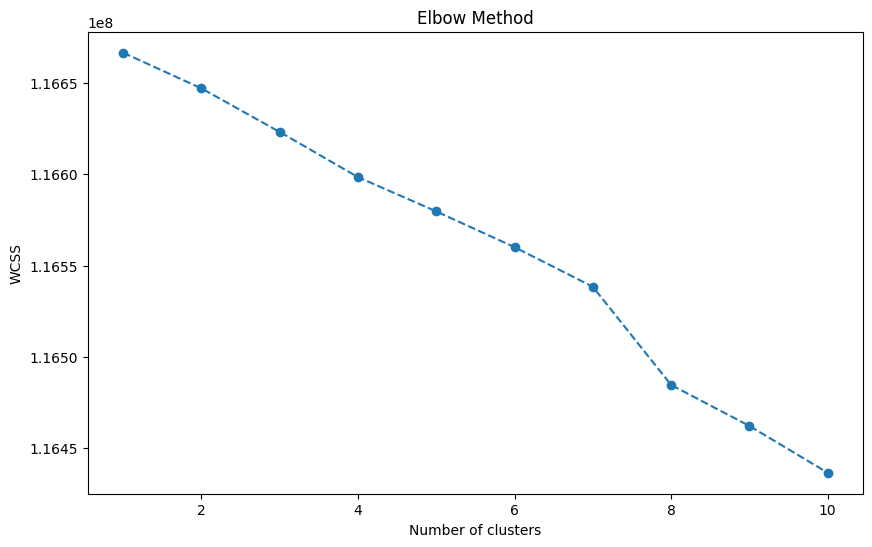

In [5]:
# Choose the number of clusters with the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Assuming optimal clusters based on the Elbow Method is 3.
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

Step 5: Identifying Important Features

After clustering, i use a RandomForestClassifier to predict the cluster labels based on the features. The classifier's feature importances give insights into which features are most significant in determining the cluster membership. This step highlights the characteristics that differentiate the clusters, providing valuable insights into what aspects of the accommodations contribute most to their categorization.

Accuracy: 0.9970342410353195
Confusion Matrix:
 [[   0    1    0]
 [   0 3688    0]
 [   0   10   10]]


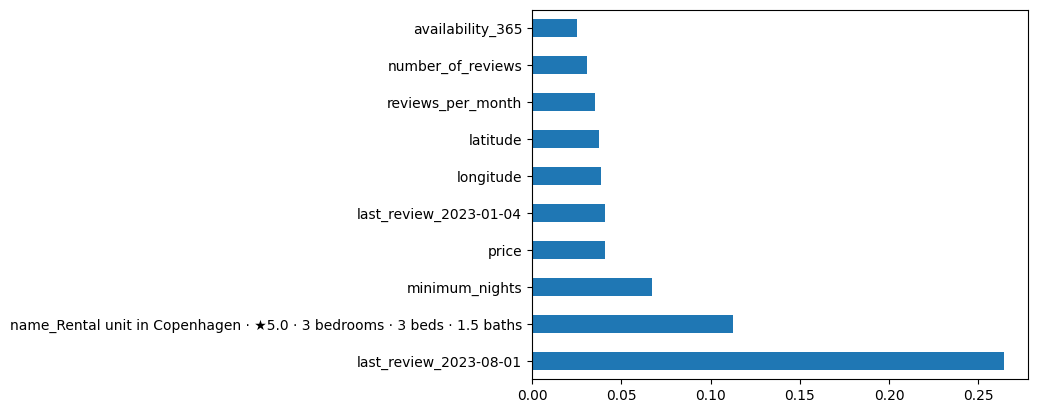

In [6]:
# Prepare features and target for the classification
X = df_scaled  # Features from the scaled DataFrame
y = df['Cluster']  # Cluster labels as the target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Predicting the Test set results
y_pred = rfc.predict(X_test)

# Evaluating the results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance
feature_importances = pd.Series(rfc.feature_importances_, index=df.columns[:-1])
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

Step 6: Summary

The analysis begins by preparing the Airbnb Copenhagen listings dataset, ensuring it is clean and structured appropriately for machine learning tasks. Clustering reveals distinct groups of accommodations, categorized by their similarities. Through this process, patterns and relationships within the data emerge, offering a deeper understanding of the Airbnb market in Copenhagen.

The identification of important features uncovers the attributes that significantly influence the grouping of listings, such as location, price, and number of reviews. These insights can be invaluable for hosts to understand competitive positioning and for customers to navigate their options more effectively.

In summary, this mini-project demonstrates the power of clustering and feature importance analysis in uncovering hidden patterns and driving factors within the Airbnb accommodations data. The findings provide a foundation for further analysis and decision-making for both hosts and guests in the Copenhagen Airbnb market.